# LAPD Crime Data Analysis 2020



## Importing Necessary Libraries


In [112]:
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### Database Connection Setup


In [87]:
connection=pymysql.connect(host="localhost",user="root",password="1054",database="minicap")

## Data Exploration

In [91]:
# Query for total records
query_total_records = "SELECT COUNT(*) AS total_records FROM crime_data;"
total_records = pd.read_sql(query_total_records, connection)
print("Total Records:")
print(total_records)


#Query for column names 
query_column_names = "SHOW COLUMNS FROM crime_data;"
column_names = pd.read_sql(query_column_names, connection)
print("\nColumn Names:")
print(column_names)


# Query for unique values
query_unique_values = """
SELECT 
    COUNT(DISTINCT Crm_Cd) AS unique_crime_codes, 
    COUNT(DISTINCT AREA_NAME) AS unique_area_names, 
    COUNT(DISTINCT Status) as unique_status,
    COUNT(DISTINCT Vict_Sex) as unique_sex
FROM crime_data;
"""
unique_values = pd.read_sql(query_unique_values, connection)
print("\n\nUnique Values:")
print(unique_values)

Total Records:
   total_records
0            499

Column Names:
          Field    Type Null Key Default Extra
0         DR_NO     int  YES        None      
1     Date_Rptd    text  YES        None      
2      DATE_OCC    text  YES        None      
3     AREA_NAME    text  YES        None      
4        Crm_Cd     int  YES        None      
5   Crm_Cd_Desc    text  YES        None      
6      Vict_Age     int  YES        None      
7      Vict_Sex    text  YES        None      
8   Premis_Desc    text  YES        None      
9        Status    text  YES        None      
10     Location    text  YES        None      
11          LAT  double  YES        None      
12          LON  double  YES        None      


Unique Values:
   unique_crime_codes  unique_area_names  unique_status  unique_sex
0                  42                 19              4           4


#### Summary: This dataset contains 499 crime records with 13 columns including information such as the date reported, date of occurrence, area name, crime code, crime code description, victim's age and sex, premises description, status, location coordinates (latitude and longitude). 

#### There are 42 unique crime codes, 19 unique area names, 4 unique statuses, and 4 unique victim sexes recorded in the dataset. 

## Temporal Analysis

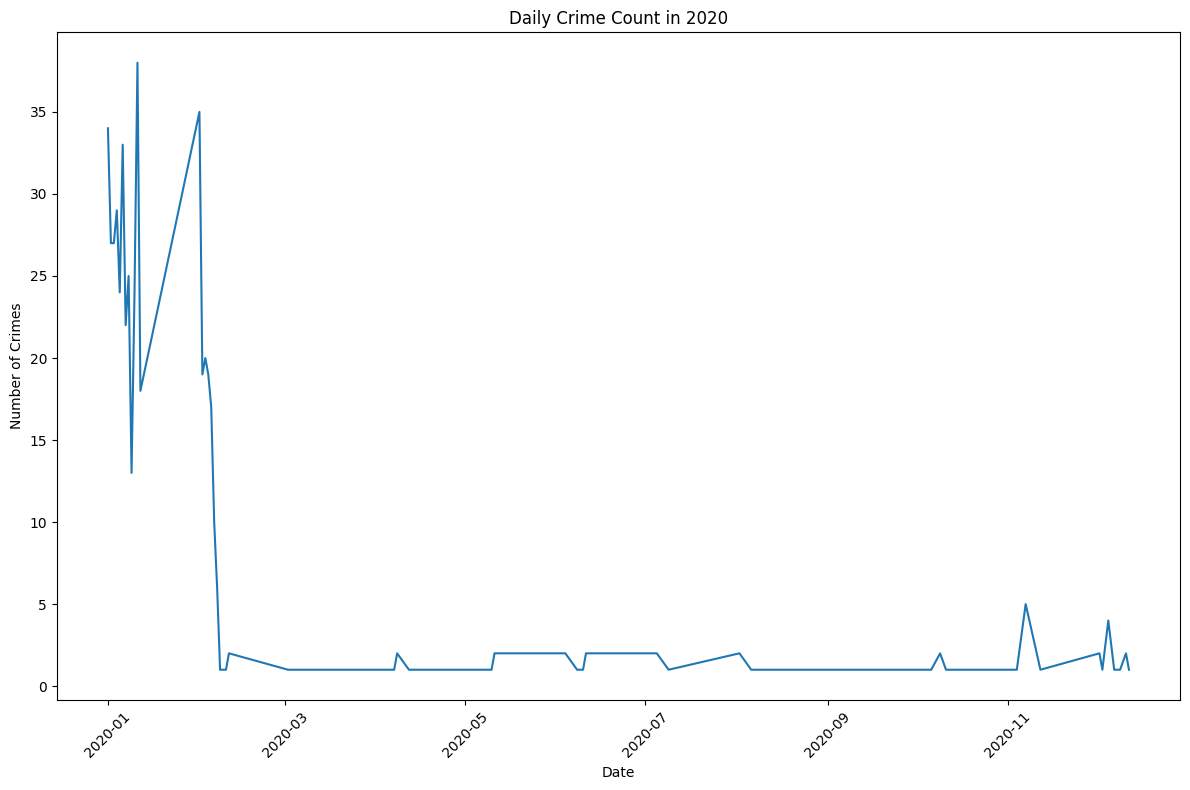

In [153]:
# Temporal Analysis SQL query
query_temporal_analysis = """
SELECT DATE_OCC, COUNT(*) AS Crime_Count 
FROM crime_data 
GROUP BY DATE_OCC;
"""
temporal_data_simple = pd.read_sql(query_temporal_analysis, connection)

# Converting DATE_OCC to datetime to extract the year and month for plotting
temporal_data_simple['DATE_OCC'] = pd.to_datetime(temporal_data_simple['DATE_OCC'])

# Plotting daily crime counts
plt.figure(figsize=(12, 8))
sns.lineplot(x='DATE_OCC', y='Crime_Count', data=temporal_data_simple)
plt.title('Daily Crime Count in 2020')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Insight: The data reveals a significant decrease in overall crime rates following COVID-19 lockdowns, highlighting the impact of reduced public activity on urban safety. 

## Spatial Analysis

In [105]:
# SQL query for spatial data
query_spatial_data = "SELECT LAT, LON, AREA_NAME FROM crime_data WHERE LAT IS NOT NULL AND LON IS NOT NULL AND Location IS NOT NULL;"
spatial_data = pd.read_sql(query_spatial_data, connection)
spatial_data.nunique()

LAT          35
LON          29
AREA_NAME    19
dtype: int64

Index(['LAT', 'LON', 'AREA_NAME'], dtype='object')


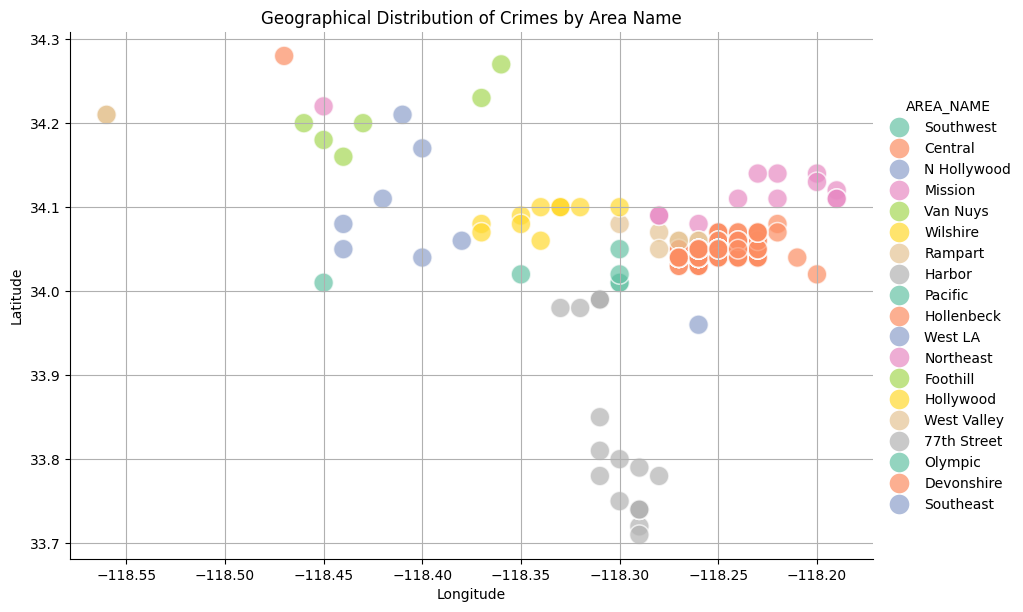

In [133]:
print(spatial_data.columns)

sns.relplot(data= spatial_data, x='LON', y='LAT', hue='AREA_NAME',palette='Set2', kind='scatter',  s=200, alpha=0.7, height=6, aspect=1.5)

plt.title('Geographical Distribution of Crimes by Area Name')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [131]:
import folium
from folium.plugins import HeatMap
import seaborn as sns

# Assuming 'spatial_data' is the DataFrame containing the crime data
map_center = [spatial_data['LAT'].mean(), spatial_data['LON'].mean()]
crime_map_with_popup = folium.Map(location=map_center, zoom_start=12)

# Add a heatmap to the map
HeatMap(data=spatial_data[['LAT', 'LON']], radius=10).add_to(crime_map_with_popup)

# Adding colored dots for each crime location with popups showing LAT or LON
for idx, row in spatial_data.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=2,
        color=color_dict[row['AREA_NAME']],  # Referencing the color_dict from the previous code
        fill=True,
        fill_color=color_dict[row['AREA_NAME']],
        popup=f"Lat, Lon: {row['LAT']}, {row['LON']}"  # Popup showing lat or lon
    ).add_to(crime_map_with_popup)

# Display the map with popups
crime_map_with_popup


## Victim Demographics

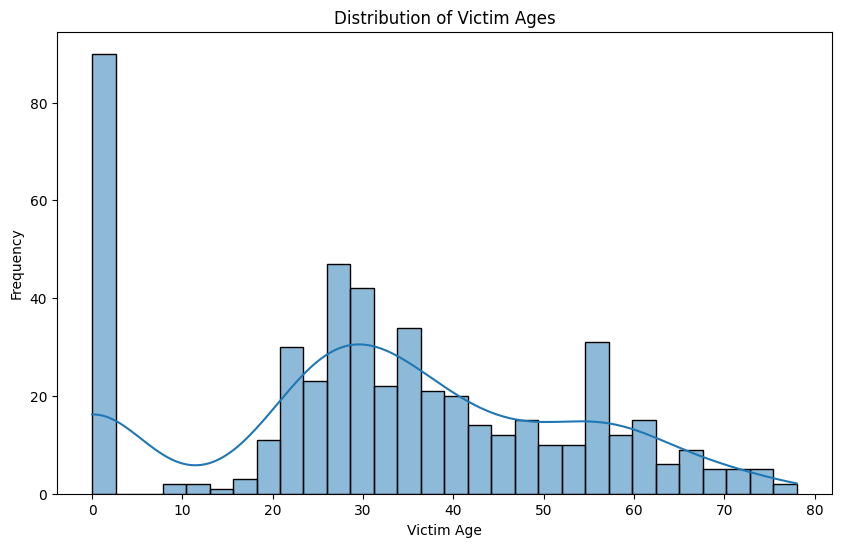

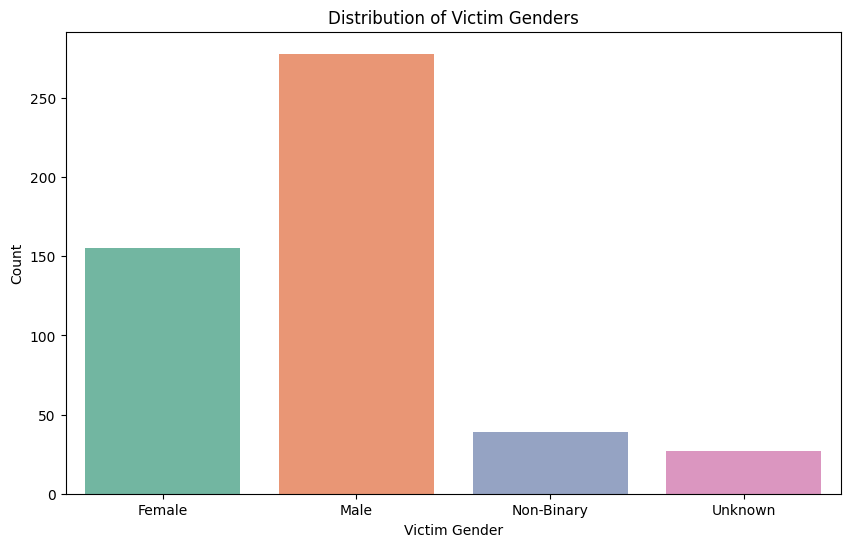

In [125]:
# Assuming database connection 'connection' is already established

# Query for victim ages and genders
query_victim_demo = "SELECT Vict_Age, Vict_Sex FROM crime_data WHERE Vict_Age IS NOT NULL AND Vict_Sex IS NOT NULL;"
victim_demo_data = pd.read_sql(query_victim_demo, connection)

# Visualization of Victim Ages
plt.figure(figsize=(10, 6))
sns.histplot(victim_demo_data['Vict_Age'], bins=30, kde=True)
plt.title('Distribution of Victim Ages')
plt.xlabel('Victim Age')
plt.ylabel('Frequency')
plt.show()


# Map 'Vict_Sex' to more descriptive categories
sex_mapping = {'M': 'Male', 'F': 'Female', 'X': 'Non-Binary', '': 'Unknown'}
victim_demo_data['Vict_Sex_Desc'] = victim_demo_data['Vict_Sex'].map(sex_mapping)

# Visualization with updated categories
plt.figure(figsize=(10, 6))
sns.countplot(x='Vict_Sex_Desc', data=victim_demo_data, palette="Set2")
plt.title('Distribution of Victim Genders')
plt.xlabel('Victim Gender')
plt.ylabel('Count')
plt.show()




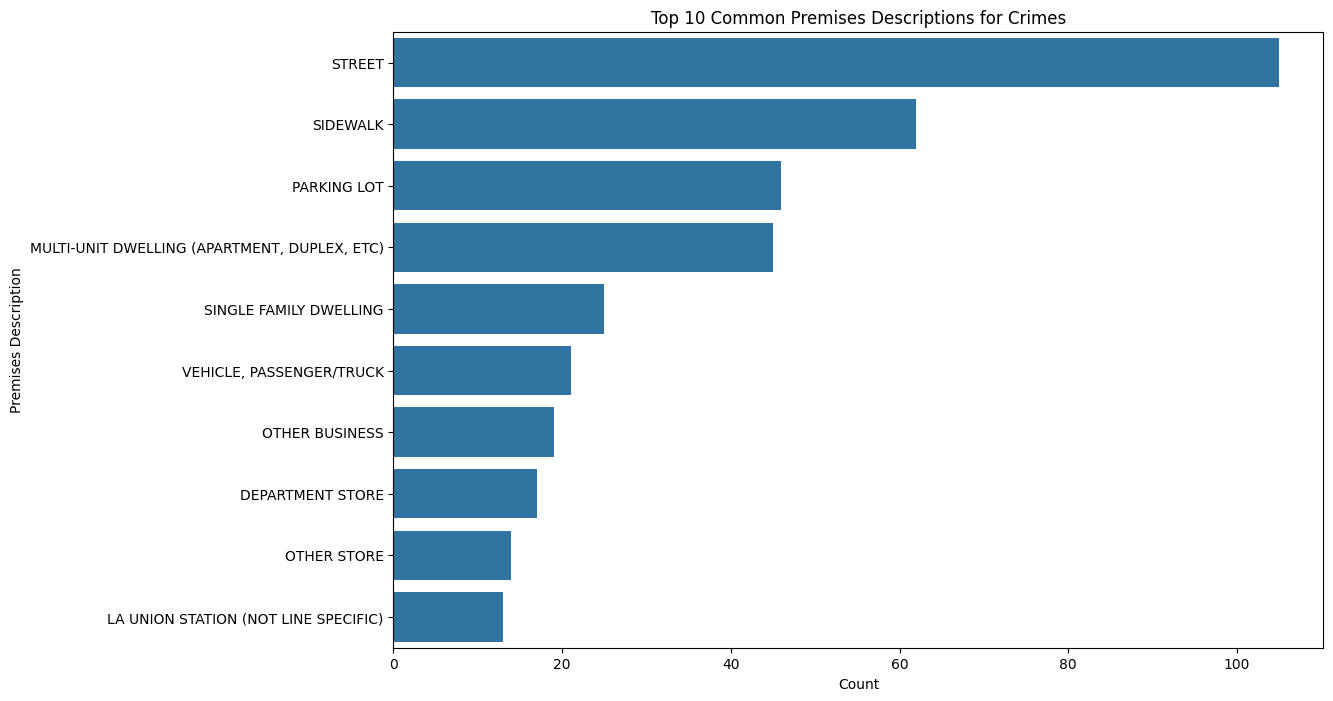

In [146]:
# Query for common premises descriptions
query_common_premises = "SELECT Premis_Desc, COUNT(*) AS Count FROM crime_data WHERE Premis_Desc IS NOT NULL GROUP BY Premis_Desc ORDER BY Count DESC;"
common_premises_data = pd.read_sql(query_common_premises, connection)

# Taking top 10 for visualization
top_premises = common_premises_data.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Premis_Desc', data=top_premises)
plt.title('Top 10 Common Premises Descriptions for Crimes')
plt.xlabel('Count')
plt.ylabel('Premises Description')
plt.show()



### Insight: The top premises for reported crimes are streets (105 incidents), sidewalks (62), parking lots (46), multi-unit dwellings (45), and single-family dwellings (25), indicating urban public spaces and residences as common crime locations.

### Status Analysis

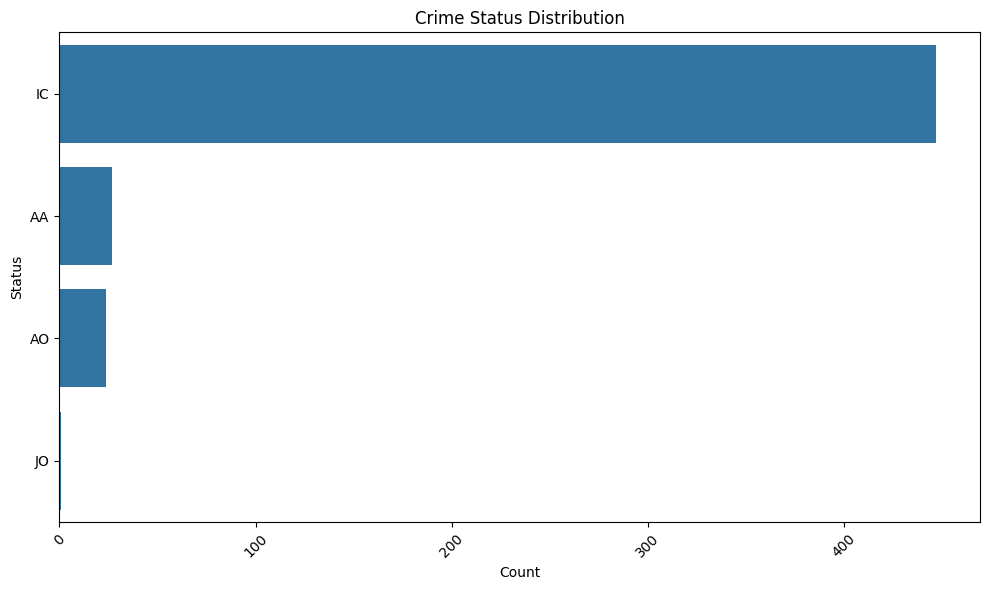

In [145]:
# Assuming the database connection 'connection' is already established for status analysis

# SQL query for crime status data
query_status_analysis = """
SELECT Status, COUNT(*) AS Count 
FROM crime_data 
GROUP BY Status 
ORDER BY Count DESC;
"""
status_data = pd.read_sql(query_status_analysis, connection)

# Visualization of Crime Status Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Status', data=status_data)
plt.title('Crime Status Distribution')
plt.xlabel('Count')
plt.ylabel('Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Insight: The majority of cases, 447, were still under investigation (IC), while 27 led to an adult arrest (AA), 24 resulted in an arrest or charge (AO), and only 1 case had just been opened (JO), indicating varied progress in case resolutions.

# Questions

## 1. Spatial Analysis: Identifying Geographical Hotspots

In [121]:
# SQL query for spatial data
query_spatial_data = "SELECT LAT, LON, AREA_NAME FROM crime_data WHERE LAT IS NOT NULL AND LON IS NOT NULL AND Location IS NOT NULL;"
spatial_data = pd.read_sql(query_spatial_data, connection)

Index(['LAT', 'LON', 'AREA_NAME'], dtype='object')


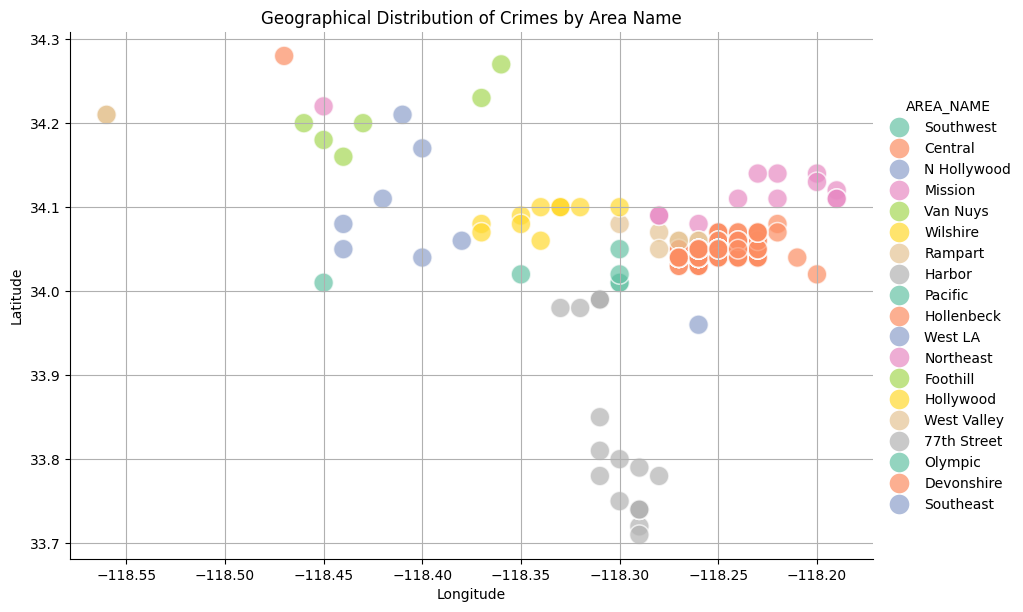

In [122]:
print(spatial_data.columns)

sns.relplot(data= spatial_data, x='LON', y='LAT', hue='AREA_NAME',palette='Set2', kind='scatter',  s=200, alpha=0.7, height=6, aspect=1.5)

plt.title('Geographical Distribution of Crimes by Area Name')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.legend(title='Area Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
#plt.tight_layout()
plt.show()

### Insight: There are clear clusters where crime incidents are densely concentrated, suggesting specific neighborhoods or areas experience higher crime rates. These hotspots may require targeted interventions and resources.

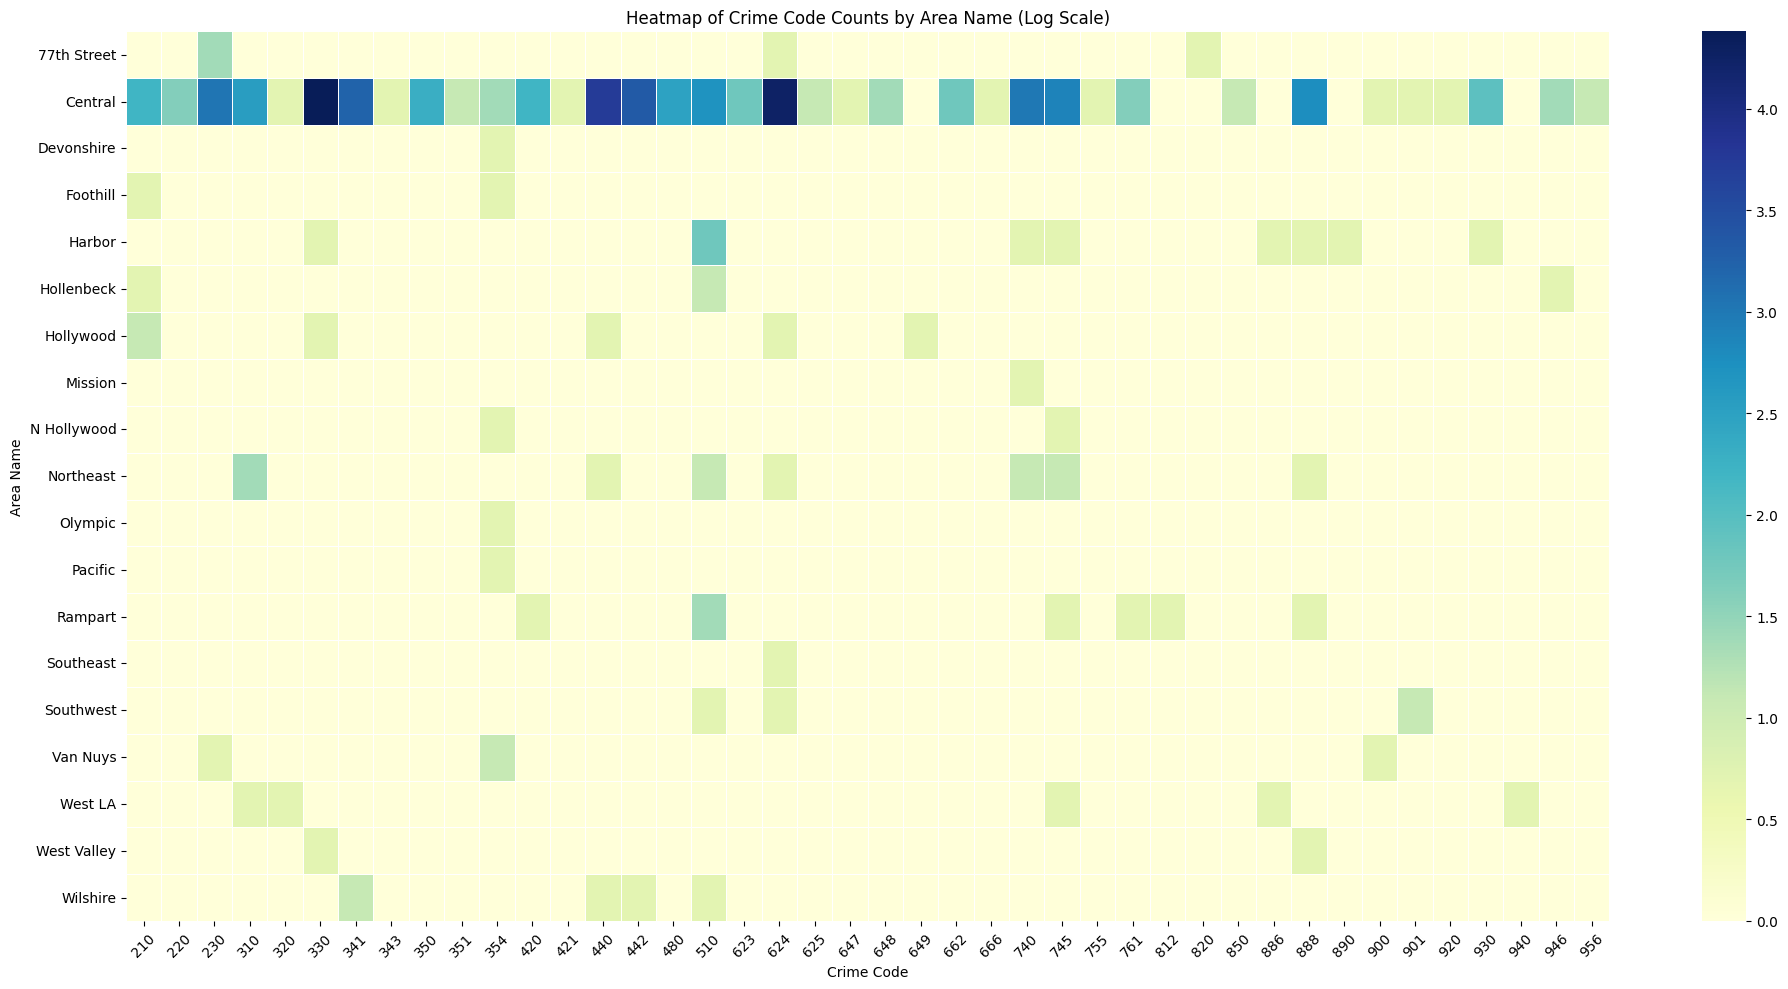

In [135]:
query = """
SELECT AREA_NAME, Crm_Cd, COUNT(*) AS Count
FROM crime_data
GROUP BY AREA_NAME, Crm_Cd
ORDER BY AREA_NAME, Crm_Cd;
"""

# Execute the query and load the data into a DataFrame
crime_counts_by_area = pd.read_sql(query, connection)

# Correctly pivot the DataFrame to get a matrix-like structure suitable for heatmap
pivot_table = crime_counts_by_area.pivot(index="AREA_NAME", columns="Crm_Cd", values="Count").fillna(0)


# Apply a logarithmic scale; add 1 to avoid log(0)
pivot_table_log = np.log1p(pivot_table)

# Generate the heatmap with the logarithmically scaled data
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table_log, cmap="YlGnBu", linewidths=.5, annot=False)
plt.title('Heatmap of Crime Code Counts by Area Name (Log Scale)')
plt.xlabel('Crime Code')
plt.ylabel('Area Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Insight: The Central area emerges as the epicenter of criminal activity, bearing the brunt of diverse crime types. Notably, crime codes 510 (Vehicle Theft) and 354 (Theft from Person) predominate, highlighting specific challenges in addressing vehicle-related thefts and personal theft incidents in this region.

## 2. Victim Demographics: Age Distribution and Gender Difference

In [123]:
query = "SELECT Vict_Age, Vict_Sex FROM crime_data WHERE Vict_Age IS NOT NULL AND Vict_Sex IS NOT NULL;"
victim_demo_data = pd.read_sql(query, connection)


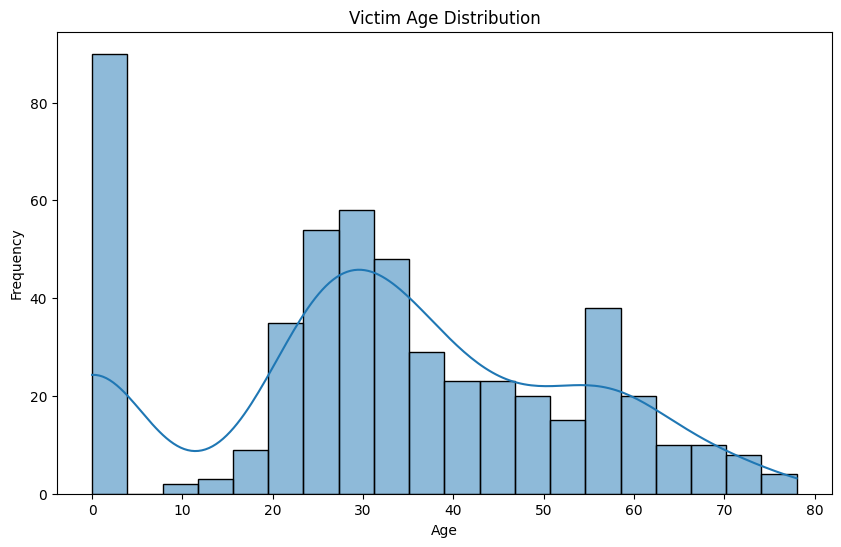

In [141]:
plt.figure(figsize=(10, 6))
sns.histplot(victim_demo_data['Vict_Age'], bins=20, kde=True)
plt.title('Victim Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


### Insight: The age distribution highlights a significant number of victims among newborns and those aged 20 to 30, indicating that younger individuals are especially vulnerable to becoming crime victims.

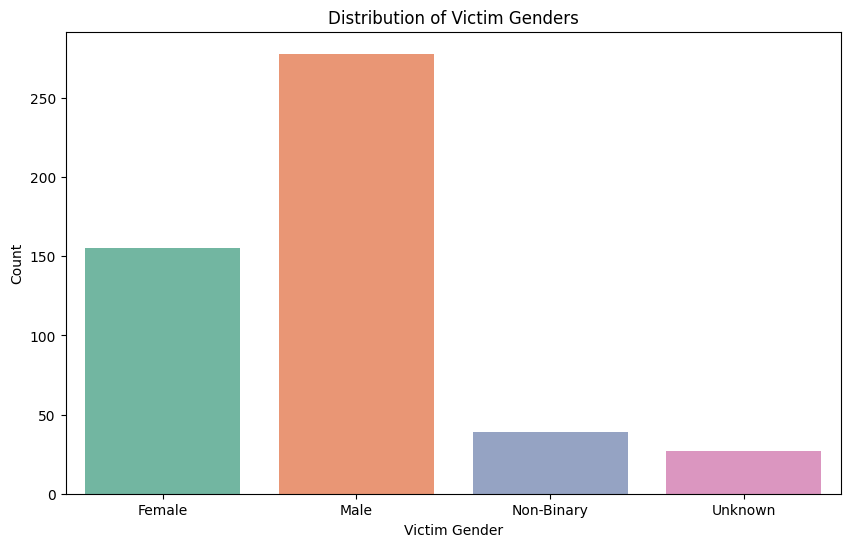

In [126]:
# Map 'Vict_Sex' to more descriptive categories
sex_mapping = {'M': 'Male', 'F': 'Female', 'X': 'Non-Binary', '': 'Unknown'}
victim_demo_data['Vict_Sex_Desc'] = victim_demo_data['Vict_Sex'].map(sex_mapping)

# Visualization with updated categories
plt.figure(figsize=(10, 6))
sns.countplot(x='Vict_Sex_Desc', data=victim_demo_data, palette="Set2")
plt.title('Distribution of Victim Genders')
plt.xlabel('Victim Gender')
plt.ylabel('Count')
plt.show()

### Insight: The comparison of crime rates by gender reveals a higher number of male victims compared to female and other genders. 

## 3. Location Analysis: Common Crime Locations

In [127]:
query = "SELECT Location, COUNT(*) AS Count FROM crime_data GROUP BY Location ORDER BY Count DESC LIMIT 10;"
location_data = pd.read_sql(query, connection)


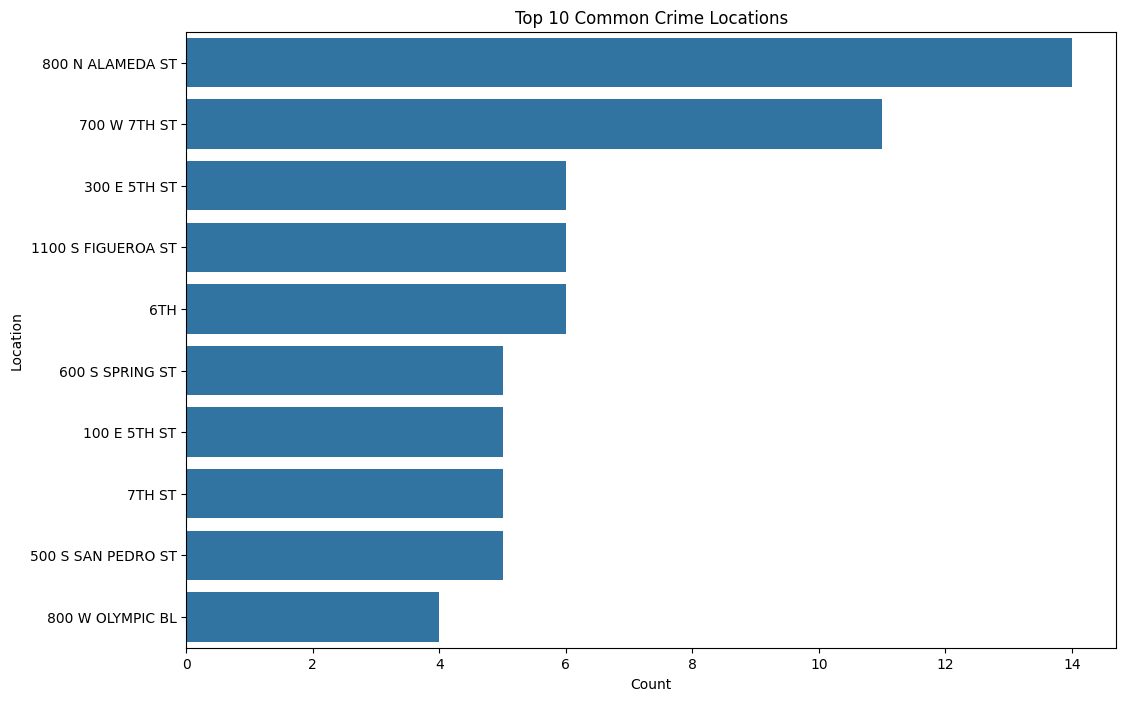

In [128]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Location', data=location_data)
plt.title('Top 10 Common Crime Locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()


### Insight: 800 N ALAMEDA ST and 700 W 7TH ST are the most reported crime locations, followed by 1100 S FIGUEROA ST and 300 E 5TH ST, indicating these spots as frequent sites for criminal incidents.

## 4. Crime Code Analysis: Distribution of Reported Crimes

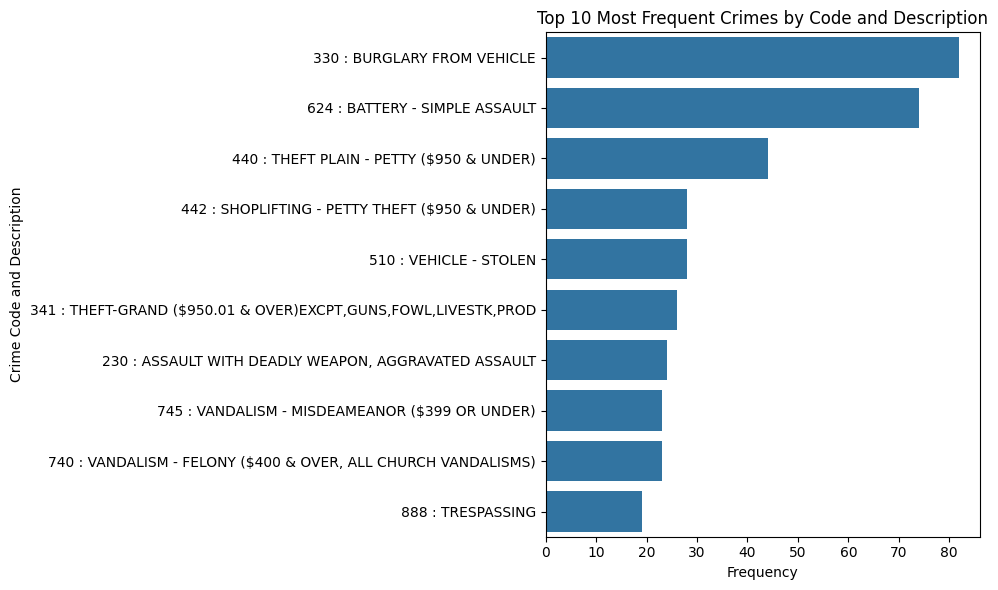

In [140]:
# Query to count occurrences of each crime code
query = """
SELECT CONCAT(Crm_Cd, ' : ', Crm_Cd_Desc) AS Crm_Code_Desc, COUNT(*) AS Count 
FROM crime_data 
GROUP BY Crm_Cd, Crm_Cd_Desc 
ORDER BY Count DESC 
LIMIT 10;
"""
crime_code_desc_counts = pd.read_sql(query, connection)

# Assuming the result of the above query is stored in a DataFrame named crime_code_desc_counts
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Crm_Code_Desc', data=crime_code_desc_counts, orient='h')
plt.title('Top 10 Most Frequent Crimes by Code and Description')
plt.xlabel('Frequency')
plt.ylabel('Crime Code and Description')
plt.tight_layout()
plt.show()


### Insight: The pronounced prevalence of Burglary from Vehicle (330) and Simple Assault (624), coupled with Theft (440, 442), highlights acute concerns for personal safety and property security.